# Perform Feature Selection using XGB Classifier
Train XGBClassifier on features set 1- samples have 16 features. Then select features with top importance scores to form a new feature set. 

##  Get the data

In [11]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import precision_score
from sklearn import cross_validation, metrics
from time import time
import pandas as pd
import collections
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort

%store -r
%store

Stored variables and their in-db values:
X_16_val                  -> array([[ 0.10924883,  1.83030605, -0.14807631, ...
X_32_val                  -> array([[ 0.66944195,  0.46536115,  0.79919788, ...
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.6694419
X_32train_std             -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[ -6.40490
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.1092488
X_train                   -> array([[[ 0.00119031,  0.00873315,  0.00641749, ..
X_train_std               -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_16_val                  -> array([6, 6, 5, ..., 0, 4, 1])
y_32_test                 -> defaultdict(<class 'list'>, {0: array([2, 2, 4, ..
y_32_train                -> array([0, 3, 4, ..., 0, 3, 1])
y_32_val                  -> array([2, 

In [3]:
print("Training data: ", X_train_std.shape, "and labels: ", y_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_test_std), X_test_std[18].shape, "arrays for SNR values:")
print(sorted(X_test_std.keys()))

Training data:  (80000, 16) and labels:  (80000,)
 
Test data:
Total 20 (4000, 16) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


##  Train and test

In [4]:
def train_and_test(model, train_data=X_train_std, train_labels=y_train, test_data=X_test_std, test_labels=y_test):
    
    dtrain = xgb.DMatrix(X_train_std, label=y_train)
    dtest = defaultdict(list)
    for snr in snrs:
        dtest[snr] = xgb.DMatrix(X_test_std[snr], label=y_test[snr])
    parameters = model.get_xgb_params()
    
    eval_history = xgb.cv(parameters, dtrain, metrics = 'mlogloss', nfold = 5, early_stopping_rounds = 20,
                         num_boost_round = model.get_params()['n_estimators'])
    model.set_params(n_estimators = eval_history.shape[0])
    
    eval_set = [(X_train_std, y_train), (X_test_std[10], y_test[10])]
    start = time()
    model.fit(train_data, train_labels, eval_metric = 'mlogloss', eval_set = eval_set) #fit model to data
    print("Fitting model to data took {} minutes".format(time() - start))
    
    # Compute metric for training data
    train_predict = model.predict(train_data)
    train_predict_prob = model.predict_proba(train_data)
    print("Log loss on training set =", metrics.log_loss(train_labels, train_predict_prob))
    
    # Compute metric for test data
    test_logloss = []
    for snr in snrs:
        test_predict = model.predict(test_data[snr])
        test_predict_prob = model.predict_proba(test_data[snr])
        loss = metrics.log_loss(test_labels[snr], test_predict_prob)
        test_logloss.append(loss)
    print("Log loss on test set =", np.mean(test_logloss))
    
    return model

In [5]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=2,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        num_class = 8,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
model = train_and_test(xgb1)

[0]	validation_0-mlogloss:1.95789	validation_1-mlogloss:1.83349
[1]	validation_0-mlogloss:1.86774	validation_1-mlogloss:1.65038
Fitting model to data took 1.2433075904846191 minutes
Log loss on training set = 1.86773986322
Log loss on test set = 1.86907329542


## Accuracy vs. SNR on test set

In [6]:
predictions = defaultdict(list)
accuracy = defaultdict(list)
y_pred = defaultdict(list)
   
for snr in snrs:
    y_pred[snr] = model.predict(X_test_std[snr])
    predictions[snr] = [round(value) for value in y_pred[snr]]
    accuracy[snr] = accuracy_score(y_test[snr], predictions[snr])
    print ("Test accuracy at ",snr,"dB =", accuracy[snr])

Test accuracy at  -20 dB = 0.12425
Test accuracy at  -18 dB = 0.12525
Test accuracy at  -16 dB = 0.1235
Test accuracy at  -14 dB = 0.12725
Test accuracy at  -12 dB = 0.153
Test accuracy at  -10 dB = 0.1695
Test accuracy at  -8 dB = 0.2575
Test accuracy at  -6 dB = 0.334
Test accuracy at  -4 dB = 0.3795
Test accuracy at  -2 dB = 0.37775
Test accuracy at  0 dB = 0.407
Test accuracy at  2 dB = 0.5415
Test accuracy at  4 dB = 0.73275
Test accuracy at  6 dB = 0.77825
Test accuracy at  8 dB = 0.79475
Test accuracy at  10 dB = 0.811
Test accuracy at  12 dB = 0.80825
Test accuracy at  14 dB = 0.81025
Test accuracy at  16 dB = 0.80325
Test accuracy at  18 dB = 0.81125


## Importance score

In [7]:
feature_names = ['f'+str(i) for i in range(1,17)]
print("Feature importance scores- highest first")
df1 = pd.DataFrame(data = {'Features':feature_names, 'Importance Scores': model.feature_importances_})
sorted_df = df1.sort_values(by = ['Importance Scores'], ascending = False)
sorted_df.reset_index(inplace = True)
del sorted_df['index']
sorted_df

Feature importance scores- highest first


,Features,Importance Scores
0,f14,0.194570
1,f5,0.158371
2,f6,0.115385
3,f13,0.115385
4,f10,0.095023
5,f9,0.090498
6,f1,0.065611
7,f11,0.036199
8,f15,0.036199
9,f12,0.029412


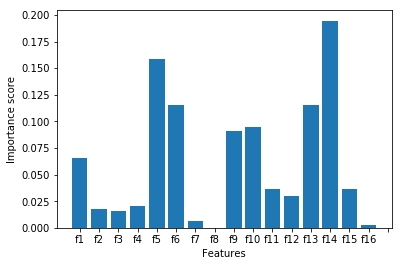

Scores using XGBoost's function:


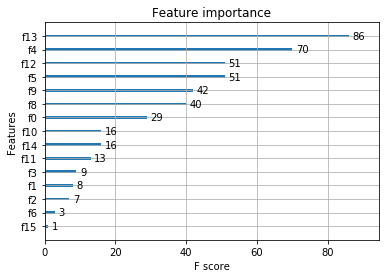

In [8]:
%matplotlib inline
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xlabel("Features")
plt.xticks(np.arange(X_train_std.shape[1]+1), feature_names)
plt.ylabel("Importance score")
plt.show()
print("Scores using XGBoost's function:")
xgb.plot_importance(model, ylabel = 'Features')

## Feature Selection

In [9]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
thresholds

array([ 0.        ,  0.00226244,  0.00678733,  0.0158371 ,  0.01809955,
        0.02036199,  0.02941176,  0.0361991 ,  0.0361991 ,  0.06561086,
        0.09049774,  0.09502263,  0.11538462,  0.11538462,  0.15837105,
        0.19457014], dtype=float32)

## On training set

In [13]:
train_accs = []
num_features = []
thresh_vals = []

for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    #selecting features based on importance weights
    #features whose importance is >= thresh are kept, and the remaining discarded
    
    select_X_train = selection.transform(X_train_std)
    n_features = select_X_train.shape[1]
    print("Top {} features selected".format(n_features))
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    #Evaluate model on training set
    y_pred = selection_model.predict(select_X_train)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_train, predictions)
    print("Thresh=%.3f, n_features=%d, Accuracy: %.2f%%" % (thresh, n_features, accuracy*100.0))
    print("  ")
    train_accs.append(accuracy)
    num_features.append(n_features)
    thresh_vals.append(thresh)

Top 16 features selected
Thresh=0.000, n_features=16, Accuracy: 50.07%
  
Top 15 features selected
Thresh=0.002, n_features=15, Accuracy: 50.07%
  
Top 14 features selected
Thresh=0.007, n_features=14, Accuracy: 50.07%
  
Top 13 features selected
Thresh=0.016, n_features=13, Accuracy: 50.05%
  
Top 12 features selected
Thresh=0.018, n_features=12, Accuracy: 50.10%
  
Top 11 features selected
Thresh=0.020, n_features=11, Accuracy: 50.15%
  
Top 10 features selected
Thresh=0.029, n_features=10, Accuracy: 50.08%
  
Top 9 features selected
Thresh=0.036, n_features=9, Accuracy: 50.13%
  
Top 9 features selected
Thresh=0.036, n_features=9, Accuracy: 50.13%
  
Top 7 features selected
Thresh=0.066, n_features=7, Accuracy: 49.99%
  
Top 6 features selected
Thresh=0.090, n_features=6, Accuracy: 48.70%
  
Top 5 features selected
Thresh=0.095, n_features=5, Accuracy: 48.18%
  
Top 4 features selected
Thresh=0.115, n_features=4, Accuracy: 48.16%
  
Top 4 features selected
Thresh=0.115, n_features=4

In [21]:
df = pd.DataFrame(data= {'Threshold':thresh_vals,'n_features':num_features, 'Training accuracy':train_accs})
sorted_df = df.sort_values(by = ['Training accuracy'], ascending = False)
print(sorted_df)
sorted_df.reset_index(inplace = True) #reset because sorting messed up the indices
idx = sorted_df['Training accuracy'].idxmax()
sel_row= sorted_df.iloc[idx]
best_features = int(sel_row['n_features'])
best_thresh = sel_row['Threshold']
print('Best training accuracy is obtained upon selection of top {} features (according to importance score)'.format(best_features))
print("The corresponding threshold value is {}".format(best_thresh))

    Threshold  Training accuracy  n_features
5    0.020362           0.501513          11
7    0.036199           0.501300           9
8    0.036199           0.501300           9
4    0.018100           0.501038          12
6    0.029412           0.500750          10
0    0.000000           0.500700          16
1    0.002262           0.500700          15
2    0.006787           0.500700          14
3    0.015837           0.500500          13
9    0.065611           0.499925           7
10   0.090498           0.486988           6
11   0.095023           0.481750           5
12   0.115385           0.481637           4
13   0.115385           0.481637           4
14   0.158371           0.424088           2
15   0.194570           0.311350           1
Best training accuracy is obtained upon selection of top 11 features (according to importance score)
The corresponding threshold value is 0.020361991599202156


## Modify training and test data to include only selected features

In [23]:
X_test_new = defaultdict(list)

selection = SelectFromModel(model, threshold = best_thresh, prefit=True)

X_train_new  = selection.transform(X_train_std)
n_features = select_X_train.shape[1]
print("Top {} features selected".format(best_features))
print("New training set {} and labels {}".format(X_train_new.shape, y_train.shape))

for snr in snrs:
    X_test_new[snr] = selection.transform(X_test_std[snr])
print("New test set {} and labels {} for each SNR value".format(X_test_new[10].shape, y_test[10].shape))

Top 11 features selected
New training set (80000, 11) and labels (80000,)
New test set (4000, 11) and labels (4000,) for each SNR value


## Store the new training and test sets in Jupyter's db

In [25]:
%store X_train_new
%store X_test_new
%store

Stored 'X_train_new' (ndarray)
Stored 'X_test_new' (defaultdict)
Stored variables and their in-db values:
X_16_val                  -> array([[ 0.10924883,  1.83030605, -0.14807631, ...
X_32_val                  -> array([[ 0.66944195,  0.46536115,  0.79919788, ...
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.6694419
X_32train_std             -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[ -6.40490
X_test_new                -> defaultdict(<class 'list'>, {0: array([[ 0.1092488
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.1092488
X_train                   -> array([[[ 0.00119031,  0.00873315,  0.00641749, ..
X_train_new               -> array([[-0.74031227,  0.23616372, -0.18182195, ...
X_train_std               -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_16_val      